In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from nutshell import ModelData, Learner, Representation

Using TensorFlow backend.


In [2]:
# Fathom concepts

# FactSet is a dataset with three columns: subject, fact_name, fact_value
#  
# You can generate a FactSet from a data with rows and columns using 
#  load_subject_rows: source dataframe has one row per subject - with columns containing fact values
#  load_fact_rows: source dataframe has many rows per subject - one row per fact name/value pair
#  results in internal fact_data dataset with one row per subject/fact



In [3]:
class FactSet:
    
    def __init__(self, factset_name):

        self.factset_name = factset_name  # this value informs the names of model files generated
        self.fact_data = pd.DataFrame()   # internal dataset with one row per subject/fact
        self.label_data = pd.DataFrame()  # internal dataset with one row per subject
        self.subject_column = ''          # name of subject id column in input dataset
        self.label_column = ''            # name label column - this will be not be used in training
        self.fact_name_column = ''        # name of fact name column in input dataset
        self.fact_value_column = ''       # name of fact value column in input dataset
        self.fact_colnames = []           # optional: list of fact columns; default is all non subject/label columns
        self.model = None
               
    def load_subject_rows(self, df):
        
        # dataset is in the format one row per subject, one fact per column
        print('Transposing data into fact rows...')
        
        #to do
        
    
    def load_fact_rows(self, df):
               
        # dataset is in the format one row per subject/fact, each row has a fact name and value column
        self.fact_data = pd.DataFrame()
        self.fact_data['subject'] = df[self.subject_column]
        self.fact_data['fact_name'] = df[self.fact_name_column]
        self.fact_data['fact_value'] = df[self.fact_value_column]
        
        print(len(df), 'fact rows loaded')
             

In [46]:
class Fathom:
    
    def __init__(self, factset):
        
        self.factset = factset
        self.model = None
        self.subject_representation = None
        self.subject_data = pd.DataFrame() # data for output for each subject
        self.fact_representation = None    
        self.fact_data = pd.DataFrame() # data for output for each fact
             
       
    def load_model(self, model=None, modeldata=None, model_name=''):
        
        # load trained model and settings
 
        if model!=None:
            self.model = model
            md = modeldata
        else:
            if model_name=='':
                model_name = self.factset.factset_name
                
            self.model = load_model(model_name + '_model.h5')
            md = ModelData(self.factset_to_df, model_name + '_settings')

        # convert model embeddings to nutshell representation objects
        self.subject_representation = Representation(self.extract_embeddings('subject', md, include_key = True))
        self.fact_representation = Representation(self.extract_embeddings('fact', md, include_key = True))  
        
        # initialize output datasets
        self.subject_data = pd.DataFrame()
        self.subject_data['subject'] = self.subject_representation.keys
        self.fact_data = pd.DataFrame()
        self.fact_data['fact'] = self.fact_representation.keys
            
    
    def extract_embeddings(self, column_name, modeldata, include_key = False):
        
        embedding_list = self.model.get_layer('embed_' + column_name).get_weights()[0]
        
        if include_key:
            key_list = []
            for i in range(0, len(embedding_list)):
                v = modeldata.index_value[column_name][i]
                key_list.append(v)
            embedding_list = [embedding_list, key_list]
            return embedding_list
        else:
            return [embedding_list]
                   
            
    def factset_to_df(self):
        
        fact_data = self.factset.fact_data
        
        dfLearn = pd.DataFrame()        
        dfLearn['subject'] = fact_data['subject']
        dfLearn['fact'] = fact_data['fact_name'].astype('str') + '/' + fact_data['fact_value'].astype('str')
        dfLearn['is_true'] = 1
        
        return dfLearn
 
    
    def learn(self, batch_size=1024, super_epochs=1, epochs=1):
     
        # training a neural net to tell which facts are true and which are false about each subject
        #  so for every true fact about a subject, there should be an equal number of false facts
        #  false facts are taken from other subjects, so they are plausible facts       
        
        print('Preparing data for model training...')
    
        dfLearn = self.factset_to_df() # convert fact_data to training data format
        
        data = ModelData(dfLearn)
        data.category_columns = ['subject','fact']
        data.label_column = 'is_true'
        data.prepare_data()
        data.add_false_rows(['subject']) # TODO: need to iterate to get rid of true facts labeled as false
        #data.prepare_data() # this wipes out false rows
        data.max_validation = 1 # overfitting is the point here - no need for validation set
        data.split_data(shuffle=True)       
        
        print('Building neural network...')
        
        model = Learner(data)
        model.dropout = .01 # overfitting is the point here - minimize dropout
        model.batch_size = batch_size
        model.build_model()
        
        print('Training neural network...')

        model.train_model(self.factset.factset_name, epochs=epochs, super_epochs=super_epochs, early_stopping='loss')
        # early_stopping='loss' is because we are trying to overfit - ignoring validation loss
        
        print ('Stored model to: ', self.factset.factset_name + '_', 'files')
        load_model(model, data) # set internal model and extract embeddings
        
        
    def generate_xy(self, generate_for='subject'):
        
        # this will reduce embedding dimensions down to 2 x,y dimensions
        #  and add the x,y values to the output data set
        
        if generate_for == 'subject':
            g_representation = self.subject_representation
            g_data = self.subject_data
        else:
            generate_for = 'fact'
            g_representation= self.fact_representation
            g_data = self.fact_data
            
        print('Calculating x,y coordinates for ' + generate_for + 's (this could take a while)...')
        rep_2d = self.subject_representation.reduce_dimensions(2)
        g_data[generate_for + '_x'] = rep_2d[:,0]
        g_data[generate_for + '_y'] = rep_2d[:,1]
        print('Added ' + generate_for + '_x and ' + generate_for + '_y columns to ' + generate_for + '_data')
        
    def generate_clusters(self, cluster_count=5, generate_for='subject'):
        
        # this will create n clusters based on subject/fact embedding values
        #  and add the cluster_n value to the output data set
        # you can run this multiple times with different n values
        #  so multiple cluster sets can be added to the output to create super/sub clusters
        
        if generate_for == 'subject':
            g_representation = self.subject_representation
            g_data = self.subject_data
        else:
            generate_for = 'fact'
            g_representation= self.fact_representation
            g_data = self.fact_data
            
        print('Calculating ' + str(cluster_count) + ' subject clusters...')
        self.subject_representation.calculate_clusters(cluster_count)
        self.subject_data['cluster_' + str(cluster_count)] = self.subject_representation.clusters
        print('Added cluster_' + str(cluster_count) + ' to subject_data')
        
    def rename_cluster(self, generate_for='subject', cluster_count=5, old_cluster_name='', new_cluster_name=''):
        
        if old_cluster_name == '':
            raise Exception('You must provide a value for old_cluster_name parameter')
        if new_cluster_name=='':
            raise Exception('You must provide a string for new_cluster_name parameter')
            
        # TO DO find column, replace new value where old value is present
                    
    
    def contrast_cluster(self, cluster_count, cluster_name):
        
        # return a dataframe containing all unique facts for the subset of subjects 
        #  where the subset is equal to members of a cluster
        
        # join all facts from factset.fact_data and join to subject_data
        #  to apply subject cluster names to each fact
        
        print('Applying subject clusters to all facts in factset...')
        dfClusterFacts = pd.merge(self.factset.fact_data, \
                                  self.subject_data[['subject', 'cluster_'+str(cluster_count)]],\
                                 on='subject')
        
        print('Aggregating fact metrics for subjects in/out of cluster...')
        dfDescribe = self.contrast_subset(df=dfClusterFacts, col_name='cluster_'+str(cluster_count), col_value=cluster_name)
        
        return dfDescribe
        
    def contrast_subset(self, df, col_name, col_value):
        
        # return a dataframe containing metrics about all unique facts in factset
        #  for each fact, provide: in_subject_count, out_subject_count, in_fact_count, out_fact_count
        
        df['in_out'] = df[col_name].apply(lambda x: 'in' if str(x)==str(col_value) else 'out')
        dfFactInOut = df.groupby(['in_out', 'fact_name', 'fact_value']).subject.nunique().reset_index()
        dfFactInOut = dfFactInOut.rename(columns={"subject": "fact_subjects"})
        dfInOut = df.groupby(['in_out']).subject.nunique().reset_index()
        dfInOut = dfInOut.rename(columns={"subject": "set_subjects"})
        total_subjects = df.subject.nunique()
        dfFactMetrics = pd.merge(dfFactInOut, dfInOut, on='in_out').reset_index()
        dfFactMetrics['fact_perc'] = dfFactMetrics.apply(lambda x: x['fact_subjects'] / x['set_subjects'], axis=1)
        dfFactsIn = dfFactMetrics[dfFactMetrics['in_out']=='in'][['fact_name', 'fact_value', 'fact_subjects', 'set_subjects', 'fact_perc']]
        dfFactsIn = dfFactsIn.rename(columns={'fact_subjects':'in_fact_subjects', 'set_subjects':'in_subjects', 'fact_perc': 'in_fact_perc'})
        dfFactsOut = dfFactMetrics[dfFactMetrics['in_out']=='out'][['fact_name', 'fact_value', 'fact_subjects', 'set_subjects', 'fact_perc']]
        dfFactsOut = dfFactsOut.rename(columns={'fact_subjects':'out_fact_subjects', 'set_subjects':'out_subjects', 'fact_perc': 'out_fact_perc'})
        dfFactMetrics = pd.merge(dfFactsIn, dfFactsOut, on=['fact_name', 'fact_value'])

        dfFactMetrics['perc_diff'] = dfFactMetrics.apply(lambda x: (x['in_fact_perc'] - x['out_fact_perc'])/x['out_fact_perc'], axis=1)
        dfFactMetrics['total_subjects'] = total_subjects
        dfFactMetrics['in_subject_perc'] = dfFactMetrics.apply(lambda x: x['in_subjects'] / x['total_subjects'], axis=1)        
        
        return dfFactMetrics
 
    def describe_contrast(self, dfContrast):
        
        # display intreseting stats about the subset/cluster
        
        print('set contains', dfContrast[0]['in_subjects'], 'subjects')
    
    def plot_clusters(self, cluster_count, generate_for='subject', max_points=500, cluster_name=''):
        
        # plot a small graph showing a sample of subjects/facts with dots colored by cluster
        
        if generate_for == 'subject':
            g_data = self.subject_data
        else:
            generate_for = 'fact'
            g_data = self.fact_data
            
        if cluster_name > '':
            g_data = g_data[g_data['cluster_'+str(cluster_count)].astype(str)==cluster_name]
            
        cl = g_data[0:max_points]['cluster_' + str(cluster_count)]
        plt.scatter(g_data[0:max_points]['subject_x'], g_data[0:max_points]['subject_y'], c=cl)

        plt.xlabel('reduced dimension x')
        plt.ylabel('reduced dimension y')

        #fig, ax = plt.subplots()
        #ax.legend()

        plt.show()        
        
               

In [276]:
df = pd.merge(fathom.factset.fact_data, \
                          fathom.subject_data[['subject', 'cluster_'+str(5)]],\
                         on='subject')




In [304]:
#df = dfxy.copy()
col_name = 'cluster_5'
col_value='4'
df['in_out'] = df[col_name].apply(lambda x: 'in' if str(x)==str(col_value) else 'out')
dfFactInOut = df.groupby(['in_out', 'fact_name', 'fact_value']).subject.nunique().reset_index()
dfFactInOut = dfFactInOut.rename(columns={"subject": "fact_subjects"})
dfInOut = df.groupby(['in_out']).subject.nunique().reset_index()
dfInOut = dfInOut.rename(columns={"subject": "set_subjects"})
total_subjects = df.subject.nunique()
dfFactMetrics = pd.merge(dfFactInOut, dfInOut, on='in_out').reset_index()
dfFactMetrics['fact_perc'] = dfFactMetrics.apply(lambda x: x['fact_subjects'] / x['set_subjects'], axis=1)
dfFactsIn = dfFactMetrics[dfFactMetrics['in_out']=='in'][['fact_name', 'fact_value', 'fact_subjects', 'set_subjects', 'fact_perc']]
dfFactsIn = dfFactsIn.rename(columns={'fact_subjects':'in_fact_subjects', 'set_subjects':'in_subjects', 'fact_perc': 'in_fact_perc'})
dfFactsOut = dfFactMetrics[dfFactMetrics['in_out']=='out'][['fact_name', 'fact_value', 'fact_subjects', 'set_subjects', 'fact_perc']]
dfFactsOut = dfFactsOut.rename(columns={'fact_subjects':'out_fact_subjects', 'set_subjects':'out_subjects', 'fact_perc': 'out_fact_perc'})
dfFactMetrics = pd.merge(dfFactsIn, dfFactsOut, on=['fact_name', 'fact_value'])

dfFactMetrics['perc_diff'] = dfFactMetrics.apply(lambda x: (x['in_fact_perc'] - x['out_fact_perc'])/x['out_fact_perc'], axis=1)
dfFactMetrics['total_subjects'] = total_subjects
dfFactMetrics['in_subject_perc'] = dfFactMetrics.apply(lambda x: x['in_subjects'] / x['total_subjects'], axis=1)


print(dfFactMetrics[0:10])



  fact_name  fact_value  in_fact_subjects  in_subjects  in_fact_perc  \
0   product           2                 3         2038      0.001472   
1   product           3                 2         2038      0.000981   
2   product          10                36         2038      0.017664   
3   product          23                 7         2038      0.003435   
4   product          25                15         2038      0.007360   
5   product          31                 1         2038      0.000491   
6   product          32                 3         2038      0.001472   
7   product          34                35         2038      0.017174   
8   product          35                 4         2038      0.001963   
9   product          43                 2         2038      0.000981   

   out_fact_subjects  out_subjects  out_fact_perc  perc_diff  total_subjects  \
0                  5          7962       0.000628   1.344063           10000   
1                  5          7962       0.0006

In [296]:
#dfFactMetrics[0:5]
dfFactsIn = dfFactMetrics[dfFactMetrics['in_out']=='in']

#[['fact_name', 'fact_value', 'fact_subjects', 'set_subjects', 'fact_perc']]


In [47]:
fathom = Fathom(facts)
#fathom.learn(super_epochs=3, epochs=15, batch_size=8192)
fathom.load_model(model_name='grocery')

In [48]:
#fathom.generate_clusters()
#fathom.generate_xy()
fathom.subject_data = dfxy

In [54]:
dfDescribe = fathom.contrast_cluster(5,4)

Applying subject clusters to all facts in factset...
Aggregating fact metrics for subjects in/out of cluster...


In [55]:
dfProducts = pd.read_csv(dataPath + 'products.csv')
dfProducts = dfProducts.rename(columns={'product_id': 'fact_value'})
dfDescribe = pd.merge(dfDescribe, dfProducts[['fact_value', 'product_name']], on='fact_value' )
#dfDescribe[0:10]

In [56]:
dfContrast = dfDescribe
print('set contains', dfContrast['in_subjects'][0], 'of', dfContrast['total_subjects'][0],\
      'subjects', dfContrast['in_subject_perc'][0]*100, '%')

min_in = 10
min_perc = .05
disp_cols = ['fact_name', 'product_name', 'in_fact_subjects', 'in_fact_perc', 'out_fact_perc','perc_diff']

dfContrastHighFilter = dfContrast[(dfContrast['in_fact_subjects']>=min_in) & (dfContrast['in_fact_perc']>=min_perc)][disp_cols]
dfContrastLowFilter = dfContrast[(dfContrast['out_fact_subjects']>=min_in) & (dfContrast['out_fact_perc']>=min_perc)][disp_cols]

print('\nhigh concentration')
print(dfContrastHighFilter.sort_values(by='perc_diff', ascending=False)[0:20])
print('\nlow concentration')
print(dfContrastLowFilter.sort_values(by='perc_diff', ascending=True)[0:20])



set contains 1802 of 10000 subjects 18.02 %

high concentration
      fact_name                               product_name  in_fact_subjects  \
4806    product                           Sweet Potato Yam               101   
10741   product                             Classic Hummus               201   
1870    product                   Grade A Large White Eggs               137   
1342    product                     Whole Grain Oat Cereal                97   
3705    product                       White Corn Tortillas                98   
11746   product         Philadelphia Original Cream Cheese               126   
9553    product            Super Soft Taco Flour Tortillas                99   
6878    product              Original Whipped Cream Cheese               121   
11380   product                                Black Beans               186   
14364   product                     Squeeze Tomato Ketchup               133   
4961    product                          All Purpose Flo

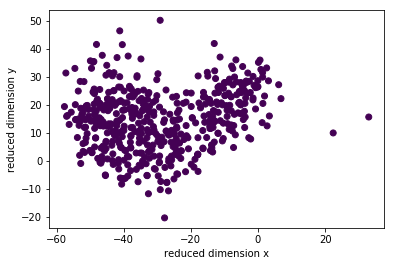

  subject  cluster_5  subject_x  subject_y
0   <pad>          3   2.326535 -10.678317
1   <unk>          3   1.905807  -9.384513
2  196610          2  15.851918  52.103973
3   32775          0  29.456978 -34.010845
4   32776          3   8.251374 -46.728134
5      13          4 -34.369453  -0.094219
6  163854          4 -19.068584  -2.283431
7   32783          1 -21.320871  21.822449
8  196624          2   4.950552  46.583263
9   65558          4 -26.247263  16.627600


In [53]:

fathom.plot_clusters(cluster_count=5, cluster_name='4')
print(fathom.subject_data[0:10])

In [42]:
dfxy = fathom.subject_data.copy()

In [5]:
# as a sample, use instacart purchases
# we will use users as subjects and products purchased as facts

dataPath = '/Users/Miles/Documents/Datasets/Instacart/'
dfProducts = pd.read_csv(dataPath + 'products.csv')
dfOrders = pd.read_csv(dataPath + 'orders.csv')
dfOrderProducts = pd.read_csv(dataPath + 'order_products__prior.csv')

In [6]:
# full set has 206K unique users
dfOrders['user_id'].nunique()

# take a random sample of 10K users - that is more managable
# also appears it takes more epochs to train the model, the more users there are :(
dfSample = pd.DataFrame()
dfSample['user_id'] = dfOrders['user_id'].unique()
dfSample = dfSample.sample(n=10000)

dfOrders = pd.merge(dfSample, dfOrders, on='user_id').reset_index()

In [7]:
# create list of user ids and products they have ordered

dfUserProducts = pd.merge(dfOrders, dfOrderProducts, on='order_id')[['user_id', 'product_id']].\
    sort_values(['user_id', 'product_id']).groupby(['user_id', 'product_id']).count().reset_index()

In [8]:
dfUserProducts['fact_name'] = 'product'

In [9]:
import csv
dfUserProducts.to_csv('grocery_userproducts.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

In [12]:
facts = FactSet('grocery')
facts.subject_column = 'user_id'
facts.fact_name_column = 'fact_name'
facts.fact_value_column = 'product_id'
facts.load_fact_rows(dfUserProducts)

649061 fact rows loaded


In [16]:
fathom = Fathom(facts)
#fathom.learn(super_epochs=3, epochs=15, batch_size=8192)
fathom.load_model(model_name='grocery')